<a href="https://colab.research.google.com/github/hamagami/ad2025/blob/main/DBSCAN%E3%81%AB%E3%82%88%E3%82%8B%E7%95%B0%E5%B8%B8%E6%A4%9C%E7%9F%A5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# DBSCAN anomaly detection on topological + aggregation datasets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# scikit-learn が無い場合:
# !pip -q install scikit-learn

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_blobs

In [3]:
# ===================== Parameters =====================
SEED = 7
MIN_SAMPLES = 10                     # DBSCAN の min_samples（k-distance の k）
AUTO_EPS_PERCENTILE = 95             # 自動 eps のパーセンタイル（ヒューリスティック）
SHOW_DATASETS = ["blobs", "moons", "circles", "spiral"]  # 表示したいデータセット
POINTS_PER_SET = 600                 # 各データセットの基礎サンプル数（外れ点注入前）
N_OUTLIERS = 50                      # 注入する外れ点数
RANDOM_OUTLIERS_RANGE = [-3.5, 3.5]  # 一様分布外れ点の範囲（x1,x2）
rng = np.random.default_rng(SEED)

In [4]:
# ===================== Generators =====================
# 凝集（クラスタ）型データ：複数のガウシアンクラスタ + 遠方の小さな外れ群 + ランダム外れ点
def gen_blobs(n=600, seed=0):
    # 正常クラスタ（やや伸びた共分散を持つ2群）
    centers = np.array([[-1.0, -0.5], [1.2, 1.0]])
    covs = [np.array([[1.8, 1.2],[1.2, 1.6]]), np.array([[1.5, 0.9],[0.9, 1.2]])]
    m = n // 2
    rng = np.random.default_rng(seed)
    X1 = rng.multivariate_normal(centers[0], covs[0], size=m)
    X2 = rng.multivariate_normal(centers[1], covs[1], size=n-m)
    X  = np.vstack([X1, X2])
    return X

# 2本の半月（トポロジカル：位相構造あり）
def gen_moons(n=600, noise=0.08, seed=0):
    X, _ = make_moons(n_samples=n, noise=noise, random_state=seed)
    return X

# 同心円（内部の穴に点を入れると位相ノイズを強調）
def gen_circles(n=600, noise=0.06, factor=0.5, seed=0):
    X, _ = make_circles(n_samples=n, noise=noise, factor=factor, random_state=seed)
    return X

# らせん（トポロジカル：滑らかな曲線集合）
def gen_spiral(n=600, noise=0.04, turns=3.5, seed=0):
    rng = np.random.default_rng(seed)
    m = n // 2
    t1 = np.linspace(0.3, turns*np.pi, m)
    t2 = t1 + np.pi
    r1 = np.linspace(0.2, 1.0, m)
    r2 = r1
    x1 = r1*np.cos(t1) + rng.normal(0, noise, m)
    y1 = r1*np.sin(t1) + rng.normal(0, noise, m)
    x2 = r2*np.cos(t2) + rng.normal(0, noise, m)
    y2 = r2*np.sin(t2) + rng.normal(0, noise, m)
    X = np.vstack([np.c_[x1, y1], np.c_[x2, y2]])
    return X

# 外れ点の注入
def inject_outliers(X, n_out=N_OUTLIERS, seed=0, kind="generic"):
    rng = np.random.default_rng(seed)
    lo, hi = RANDOM_OUTLIERS_RANGE
    uni = rng.uniform(lo, hi, size=(n_out, 2))  # ランダム外れ点

    # 凝集型の例：遠方に小さな「外れクラスタ」を追加（クラスタ外の凝集を異常として示す）
    if kind == "blobs":
        center = np.array([6.5, -6.5])
        cov = np.array([[0.4, 0.0],[0.0, 0.4]])
        small = rng.multivariate_normal(center, cov, size=max(10, n_out//3))
        return np.vstack([X, uni, small])

    # 同心円：中心の穴に点を入れて位相ノイズを強調
    if kind == "circles":
        r = rng.uniform(0.0, 0.15, size=(n_out//2,))
        ang = rng.uniform(0, 2*np.pi, size=(n_out//2,))
        hole = np.c_[r*np.cos(ang), r*np.sin(ang)]
        return np.vstack([X, uni, hole])

    return np.vstack([X, uni])


In [5]:
# ===================== DBSCAN & plotting =====================
# 自動 eps（k-distance のパーセンタイル）
def auto_eps(X_scaled, min_samples=MIN_SAMPLES, pct=AUTO_EPS_PERCENTILE):
    nn = NearestNeighbors(n_neighbors=min_samples)
    nn.fit(X_scaled)
    dists, _ = nn.kneighbors(X_scaled)
    k_dists = np.sort(dists[:, -1])
    eps = np.percentile(k_dists, pct)
    return eps, k_dists

# DBSCAN を実行し、3種類の図（生データ / 予測 / k-distance）を描画
def run_dbscan(X, title):
    # 距離ベース手法なのでスケーリングを実施
    scaler = StandardScaler()
    Xs = scaler.fit_transform(X)

    eps, k_dists = auto_eps(Xs)
    db = DBSCAN(eps=eps, min_samples=MIN_SAMPLES)
    labels = db.fit_predict(Xs)

    # コア / ノイズ / ボーダーの判定
    core_idx = getattr(db, "core_sample_indices_", None)
    is_core = np.zeros(len(Xs), dtype=bool)
    if core_idx is not None:
        is_core[core_idx] = True
    is_noise = labels == -1
    is_border = (~is_core) & (~is_noise)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f"[{title}] eps≈{eps:.3f}, min_samples={MIN_SAMPLES}, clusters={n_clusters}, noise={is_noise.sum()} / {len(X)}")

    # === plots ===
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # (A) 生データ（外れ点注入後）
    axes[0].scatter(X[:,0], X[:,1], s=12, label="Data (+ outliers)")
    axes[0].set_title(f"{title}: Raw data")
    axes[0].legend(loc="best")
    axes[0].set_xlabel("x1"); axes[0].set_ylabel("x2")

    # (B) DBSCAN 結果（クラスタ / 境界 / ノイズ）
    uniq = sorted(set(labels))
    for lab in uniq:
        m = labels == lab
        if lab == -1:
            axes[1].scatter(X[m,0], X[m,1], s=32, marker="x", label="Noise (anomalies)")
        else:
            m_core = m & is_core
            if m_core.any():
                axes[1].scatter(X[m_core,0], X[m_core,1], s=24, label=f"Cluster {lab} (core)")
            m_border = m & is_border
            if m_border.any():
                axes[1].scatter(X[m_border,0], X[m_border,1], s=16, marker="o", label=f"Cluster {lab} (border)")
    axes[1].set_title(f"{title}: DBSCAN result")
    axes[1].legend(loc="best", ncol=2)
    axes[1].set_xlabel("x1"); axes[1].set_ylabel("x2")

    # (C) k-distance プロット（エルボー近傍の eps を可視化）
    axes[2].plot(np.arange(len(k_dists)), k_dists)
    axes[2].axhline(eps, linestyle="--", label=f"Chosen eps ≈ {eps:.3f}")
    axes[2].set_title(f"{title}: k-distance (k = {MIN_SAMPLES})")
    axes[2].set_xlabel("Points sorted by k-distance")
    axes[2].set_ylabel("k-distance")
    axes[2].legend(loc="best")

    plt.tight_layout()
    plt.show()

    # CSV 保存
    out = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "label": labels,
                        "is_core": is_core.astype(int), "is_noise": is_noise.astype(int)})
    fname = f"dbscan_{title.lower().replace(' ', '_')}.csv"
    out.to_csv(fname, index=False)
    print(f"Saved: {fname}\n")
    return out

[Gaussian Blobs (aggregation)] eps≈0.521, min_samples=10, clusters=2, noise=12 / 666


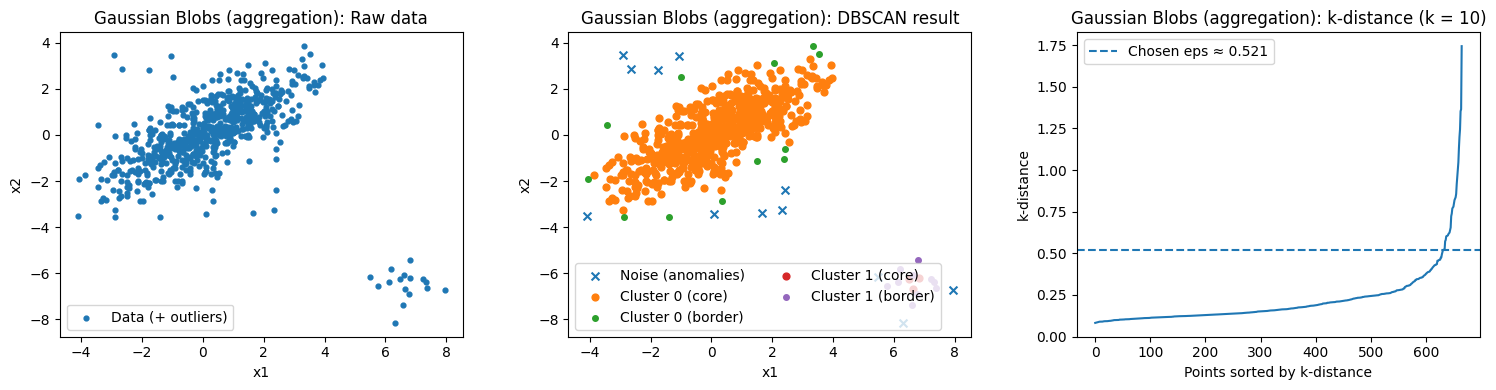

Saved: dbscan_gaussian_blobs_(aggregation).csv

[Moons] eps≈1.113, min_samples=10, clusters=1, noise=24 / 650


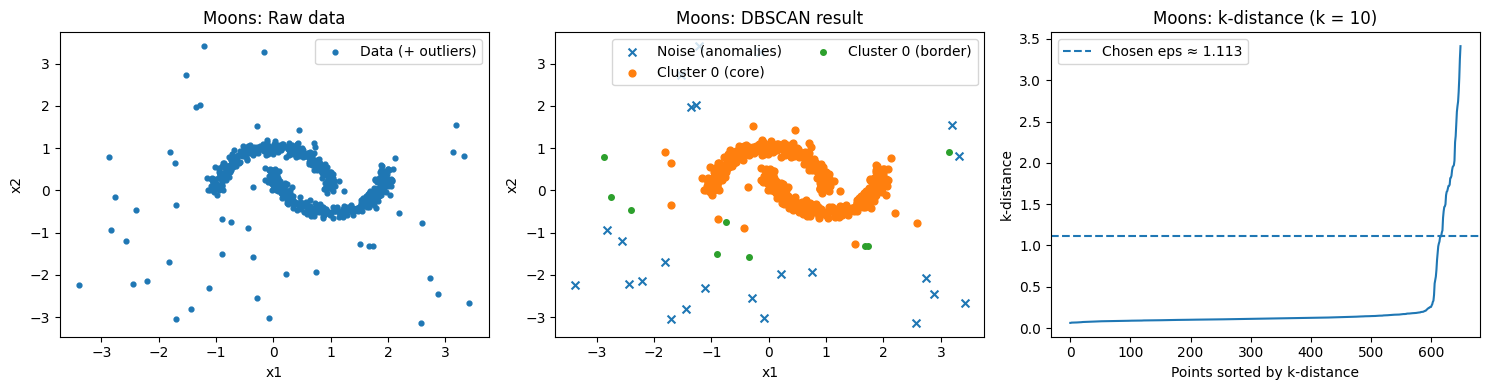

Saved: dbscan_moons.csv

[Concentric Circles] eps≈1.467, min_samples=10, clusters=1, noise=27 / 675


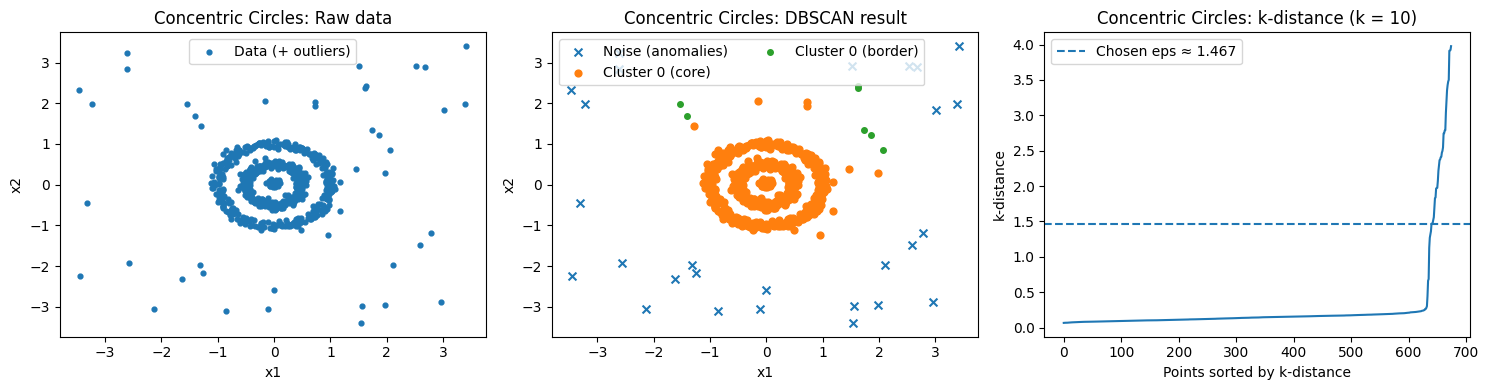

Saved: dbscan_concentric_circles.csv

[Spiral] eps≈1.822, min_samples=10, clusters=1, noise=24 / 650


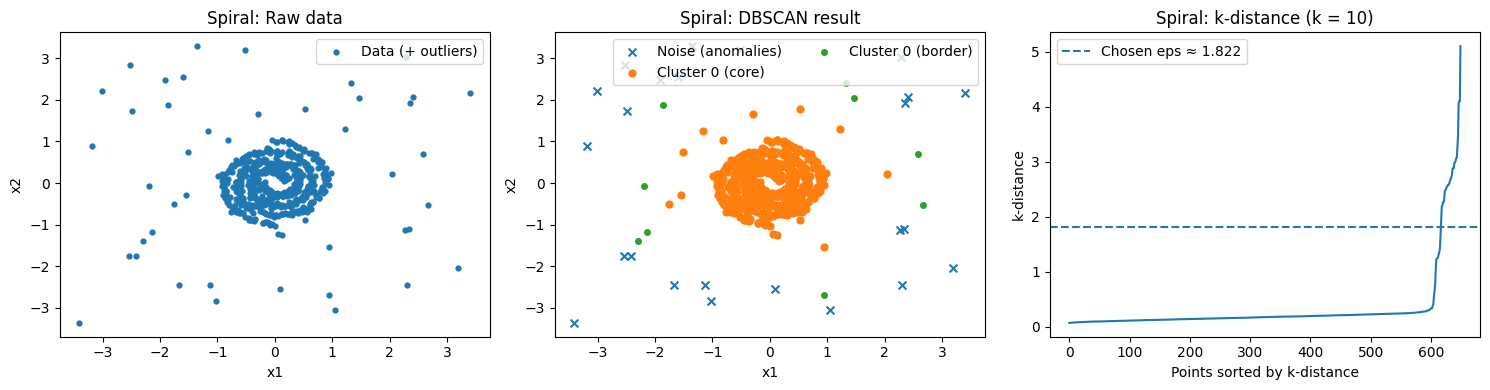

Saved: dbscan_spiral.csv



In [6]:
# ===================== Build datasets and run =====================
outputs = {}

# 凝集（クラスタ）型：ガウシアンクラスタ + 小さな外れ群 + ランダム外れ点
if "blobs" in SHOW_DATASETS:
    X = gen_blobs(n=POINTS_PER_SET, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+10, kind="blobs")
    outputs["blobs"] = run_dbscan(X, "Gaussian Blobs (aggregation)")

# トポロジカル：moons
if "moons" in SHOW_DATASETS:
    X = gen_moons(n=POINTS_PER_SET, noise=0.08, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+1, kind="generic")
    outputs["moons"] = run_dbscan(X, "Moons")

# トポロジカル：concentric circles（中央の穴にノイズを注入）
if "circles" in SHOW_DATASETS:
    X = gen_circles(n=POINTS_PER_SET, noise=0.06, factor=0.5, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+2, kind="circles")
    outputs["circles"] = run_dbscan(X, "Concentric Circles")

# トポロジカル：spiral
if "spiral" in SHOW_DATASETS:
    X = gen_spiral(n=POINTS_PER_SET, noise=0.04, turns=3.5, seed=SEED)
    X = inject_outliers(X, n_out=N_OUTLIERS, seed=SEED+3, kind="generic")
    outputs["spiral"] = run_dbscan(X, "Spiral")
